In [4]:
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

# Train test split
from sklearn.model_selection import train_test_split

# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional

2025-02-24 17:20:21.882632: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 17:20:21.898176: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 17:20:22.047138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 17:20:22.199034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740397822.344859    2633 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740397822.39

In [5]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

## Loading Dataset

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/kenneth-lee-ch/SMS-Spam-Classification/master/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
# renaming colums
df = df[['v1', 'v2']]
df.rename(columns={'v1': 'label', 'v2': 'text'}, inplace=True)
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.describe()


,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [10]:
df.groupby('label').describe().T

label                           ham  \
text count                     4825   
     unique                    4516   
     top     Sorry, I'll call later   
     freq                        30   

label                                                     spam  
text count                                                 747  
     unique                                                653  
     top     Please call our customer service representativ...  
     freq                                                    4

## Visualizations

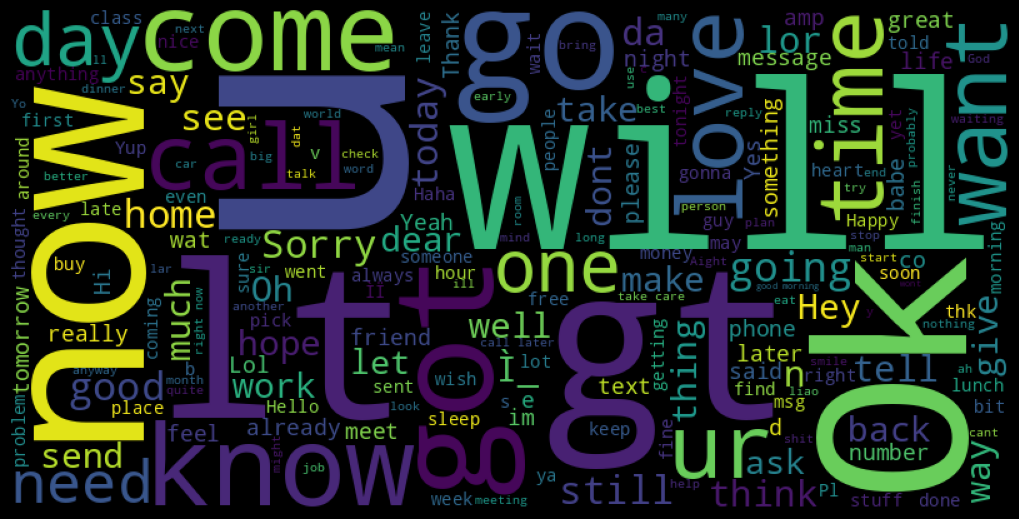

In [11]:
ham_cloud = WordCloud(width=800, height=400, background_color='black', stopwords=STOPWORDS).generate(' '.join(df[df['label'] == 'ham']['text']))
plt.figure(figsize=(10, 8), facecolor='k')
plt.imshow(ham_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

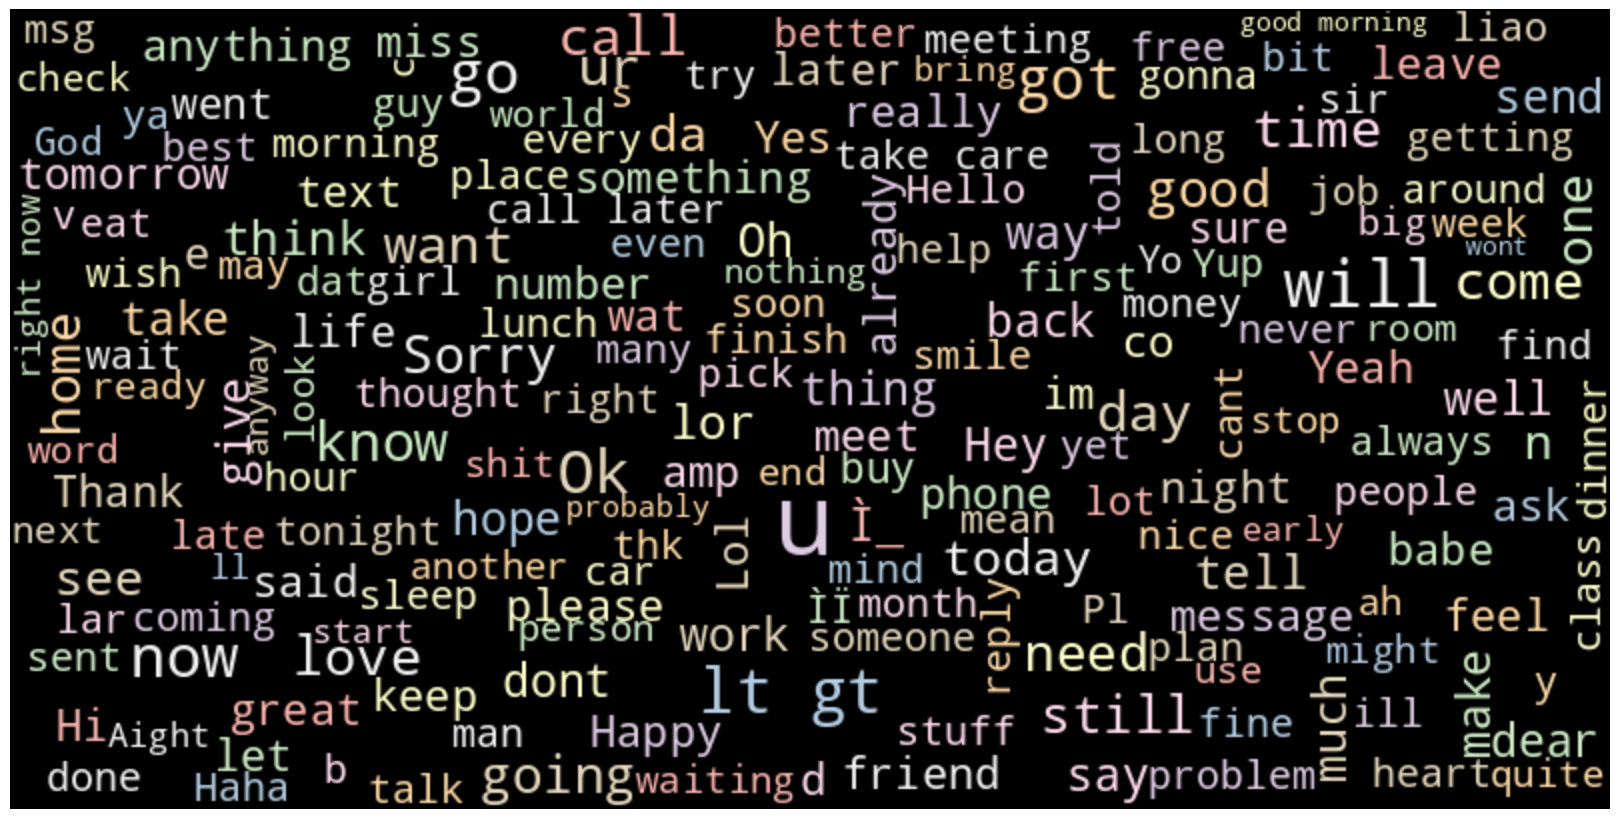

In [12]:
ham_text = ' '.join(df[df['label'] == 'ham']['text'])
ham_cloud = WordCloud(width=800, height=400, background_color='black', stopwords=STOPWORDS, max_font_size=50, colormap='Pastel1').generate(ham_text)
plt.figure(figsize=(16, 10))
plt.imshow(ham_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

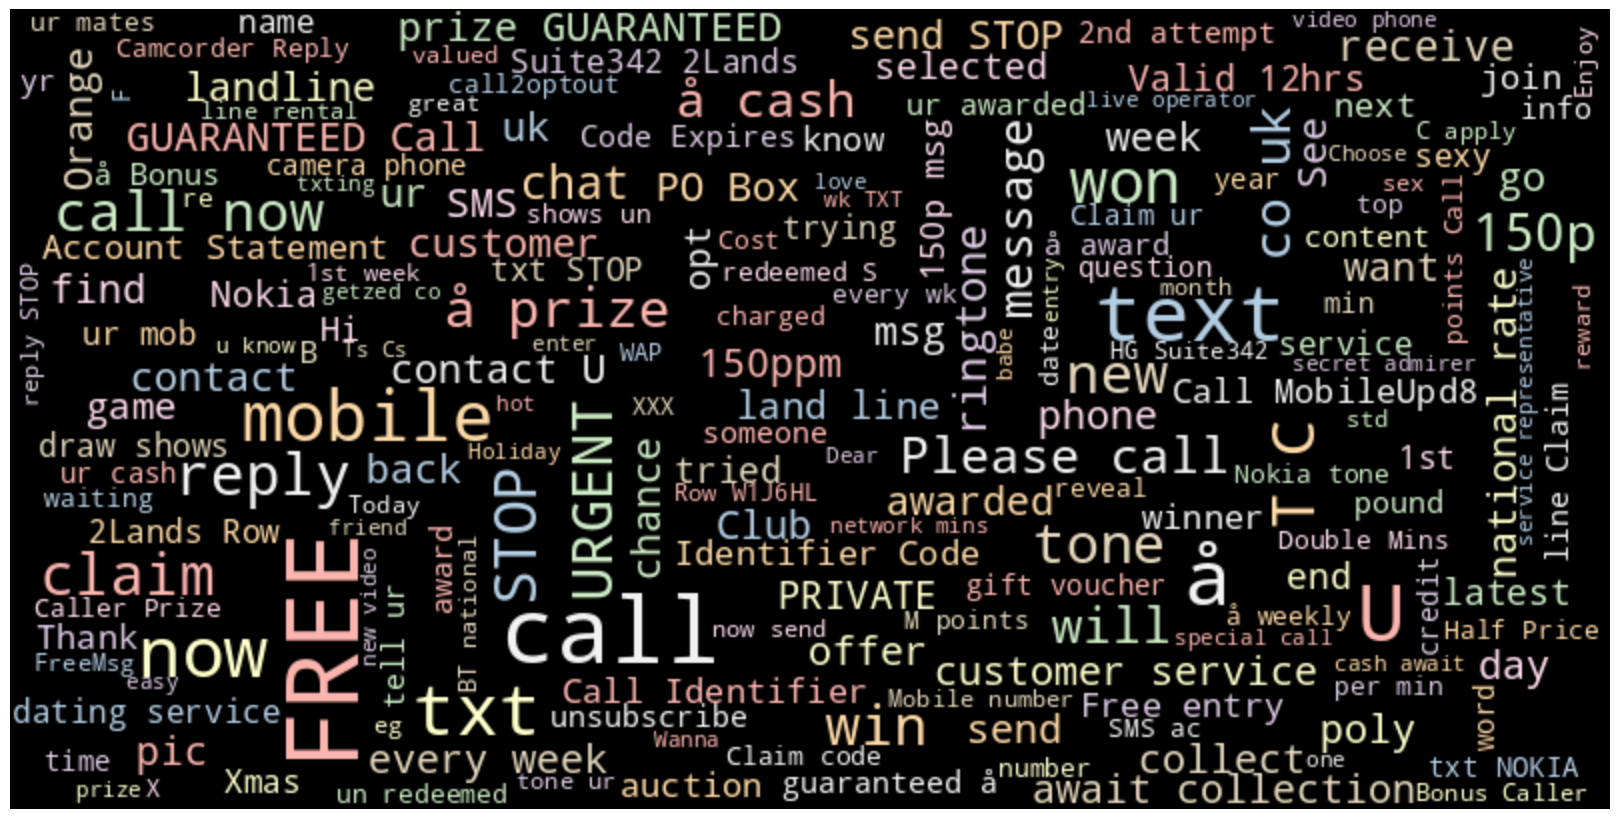

In [13]:
spam = ' '.join(df[df['label'] == 'spam']['text'])
spam_cloud = WordCloud(width=800, height=400, background_color='black', stopwords=STOPWORDS, max_font_size=50, colormap='Pastel1').generate(spam)
plt.figure(figsize=(16, 10))
plt.imshow(spam_cloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Data Imbalance

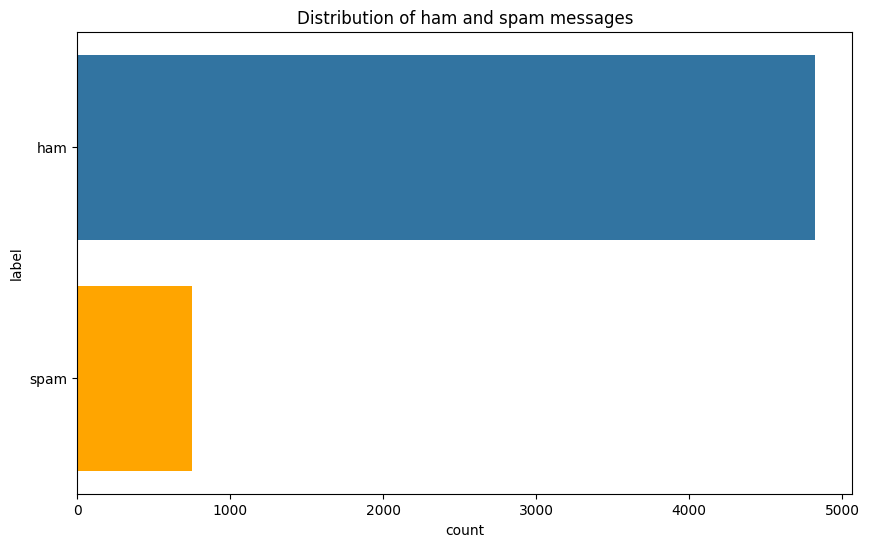

In [14]:
plt.figure(figsize=(10, 6))
sns.countplot(df.label)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Distribution of ham and spam messages')
plt.show()

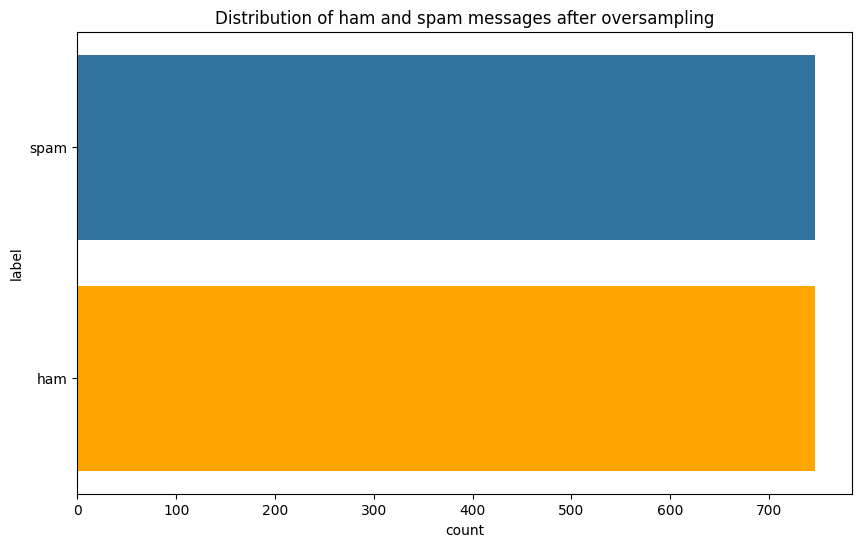

In [15]:
# oversample spam
spam = df[df['label'] == 'spam']
ham = df[df['label'] == 'ham']

ham = ham.sample(n = len(spam), random_state=44)

df = pd.concat([ham, spam], axis=0).reset_index(drop=True)
df = df.sample(frac=1, random_state=44).reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.countplot(df.label)
plt.gca().patches[1].set_facecolor('orange')
plt.title('Distribution of ham and spam messages after oversampling')
plt.show()

In [16]:
# save it as first set
df.to_csv('spam_oversampled.csv', index=False)


## Text Processing

In [17]:
msg_df = pd.read_csv('spam_oversampled.csv')
msg_df.head()

,label,text
0,spam,You have won a Nokia 7250i. This is what you g...
1,spam,WIN URGENT! Your mobile number has been awarde...
2,ham,I have no idea where you are
3,ham,U free on sat rite? U wan 2 watch infernal aff...
4,ham,Am on the uworld site. Am i buying the qbank o...


In [18]:
msg_df['text_length'] = msg_df['text'].apply(len)
msg_df.head()

,label,text,text_length
0,spam,You have won a Nokia 7250i. This is what you g...,151
1,spam,WIN URGENT! Your mobile number has been awarde...,147
2,ham,I have no idea where you are,28
3,ham,U free on sat rite? U wan 2 watch infernal aff...,77
4,ham,Am on the uworld site. Am i buying the qbank o...,98


In [19]:
msg_df['text_type'] = msg_df['label'].map({'ham': 0, 'spam': 1})
msg_labels = msg_df['text_type'].values
msg_df.head()

,label,text,text_length,text_type
0,spam,You have won a Nokia 7250i. This is what you g...,151,1
1,spam,WIN URGENT! Your mobile number has been awarde...,147,1
2,ham,I have no idea where you are,28,0
3,ham,U free on sat rite? U wan 2 watch infernal aff...,77,0
4,ham,Am on the uworld site. Am i buying the qbank o...,98,0


## Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(msg_df['text'], msg_labels, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1195,) (299,) (1195,) (299,)


## Tokenization


In [21]:
max_len = 50
trunc_type = 'post'
padding_type = 'post'
oov_token = '<OOV>'
vocab_size = 500

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token, char_level=False)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

total_words = len(word_index)
total_words

4098

In [22]:
# sequence and padding

# for train data
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

# for test data
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

print('Shape of training padded:', training_padded.shape)
print('Shape of testing padded:', testing_padded.shape)

Shape of training padded: (1195, 50)
Shape of testing padded: (299, 50)


## Dense Model Architecture and Training

In [23]:
# define parameters
vocab_size = 500
embedding_dim = 16
drop_value = 0.2
n_dense = 24

In [24]:
# define model architecture

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, max_len))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

2025-02-24 17:20:47.013353: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 16)         │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,433 (32.94 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

Epoch 1/30
38/38 - 3s - 69ms/step - accuracy: 0.5038 - loss: 0.6758 - val_accuracy: 0.4415 - val_loss: 0.6695
Epoch 2/30
38/38 - 0s - 10ms/step - accuracy: 0.5582 - loss: 0.6267 - val_accuracy: 0.6421 - val_loss: 0.6189
Epoch 3/30
38/38 - 0s - 10ms/step - accuracy: 0.7230 - loss: 0.5689 - val_accuracy: 0.7826 - val_loss: 0.5562
Epoch 4/30
38/38 - 0s - 12ms/step - accuracy: 0.8293 - loss: 0.4961 - val_accuracy: 0.8261 - val_loss: 0.4721
Epoch 5/30
38/38 - 0s - 11ms/step - accuracy: 0.8586 - loss: 0.4205 - val_accuracy: 0.8562 - val_loss: 0.4046
Epoch 6/30
38/38 - 0s - 10ms/step - accuracy: 0.8736 - loss: 0.3530 - val_accuracy: 0.8696 - val_loss: 0.3472
Epoch 7/30
38/38 - 0s - 11ms/step - accuracy: 0.8996 - loss: 0.3054 - val_accuracy: 0.8863 - val_loss: 0.2880
Epoch 8/30
38/38 - 0s - 13ms/step - accuracy: 0.9172 - loss: 0.2612 - val_accuracy: 0.8997 - val_loss: 0.2438
Epoch 9/30
38/38 - 0s - 13ms/step - accuracy: 0.9331 - loss: 0.2118 - val_accuracy: 0.9130 - val_loss: 0.2081
Epoch 10/3

In [26]:
model.evaluate(testing_padded, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9685 - loss: 0.1269 


[0.10352462530136108, 0.9698996543884277]

In [27]:
train_dense_results = model.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_dense_results = model.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)
print(f'Train accuracy: {train_dense_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_dense_results[1]*100:0.2f}')

5/5 - 0s - 15ms/step - accuracy: 0.9782 - loss: 0.0624
2/2 - 0s - 27ms/step - accuracy: 0.9699 - loss: 0.1035
Train accuracy: 97.82
Valid accuracy: 96.99


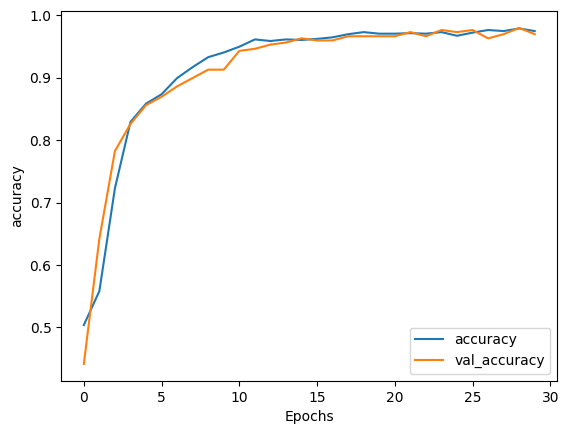

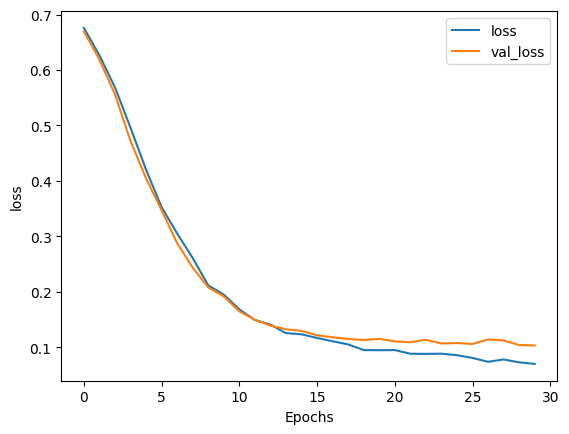

In [28]:
# plot graph of accuracy and loss over time
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [29]:
# save the model
model.save('spam_classifier.h5')

model.save('spam_classifier.keras')


In [30]:
loaded_model = tf.keras.models.load_model('spam_classifier.h5')
loaded_model.summary()
loaded_model.evaluate(testing_padded, y_test, verbose=2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 16)         │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,435 (32.95 KB)

 Trainable params: 8,433 (32.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

10/10 - 0s - 36ms/step - accuracy: 0.9699 - loss: 0.1035


[0.10352462530136108, 0.9698996543884277]

## LSTM


In [31]:
# parameters
n_lstm = 128
drop = 0.2

In [32]:
# model architecture

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_lstm.add(SpatialDropout1D(drop))
model_lstm.add(LSTM(n_lstm, return_sequences=False))
model_lstm.add(Dropout(drop))
model_lstm.add(Dense(1, activation='sigmoid'))


model_lstm.build(input_shape=(None, max_len))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 16)         │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 16)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,369 (321.75 KB)

 Trainable params: 82,369 (321.75 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history_lstm = model_lstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

Epoch 1/30
38/38 - 7s - 178ms/step - accuracy: 0.6126 - loss: 0.6059 - val_accuracy: 0.8227 - val_loss: 0.4238
Epoch 2/30
38/38 - 3s - 86ms/step - accuracy: 0.9013 - loss: 0.3122 - val_accuracy: 0.9398 - val_loss: 0.1870
Epoch 3/30
38/38 - 3s - 85ms/step - accuracy: 0.9054 - loss: 0.2885 - val_accuracy: 0.9298 - val_loss: 0.2072
Epoch 4/30
38/38 - 3s - 84ms/step - accuracy: 0.9397 - loss: 0.1996 - val_accuracy: 0.9264 - val_loss: 0.2192
Epoch 5/30
38/38 - 3s - 81ms/step - accuracy: 0.9531 - loss: 0.1629 - val_accuracy: 0.9565 - val_loss: 0.1390
Epoch 6/30
38/38 - 3s - 90ms/step - accuracy: 0.9649 - loss: 0.1382 - val_accuracy: 0.9599 - val_loss: 0.1222
Epoch 7/30
38/38 - 3s - 86ms/step - accuracy: 0.9732 - loss: 0.1135 - val_accuracy: 0.9565 - val_loss: 0.1609
Epoch 8/30
38/38 - 4s - 96ms/step - accuracy: 0.9707 - loss: 0.1032 - val_accuracy: 0.9732 - val_loss: 0.1124
Epoch 9/30
38/38 - 4s - 94ms/step - accuracy: 0.9782 - loss: 0.0967 - val_accuracy: 0.9766 - val_loss: 0.1022
Epoch 10/

In [34]:
model_lstm.evaluate(testing_padded, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9605 - loss: 0.1796


[0.14372190833091736, 0.9665551781654358]

In [35]:
train_lstm_results = model_lstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_lstm_results = model_lstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)

print(f'Train accuracy: {train_lstm_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_lstm_results[1]*100:0.2f}')

5/5 - 1s - 173ms/step - accuracy: 0.9874 - loss: 0.0525
2/2 - 0s - 163ms/step - accuracy: 0.9666 - loss: 0.1437
Train accuracy: 98.74
Valid accuracy: 96.66


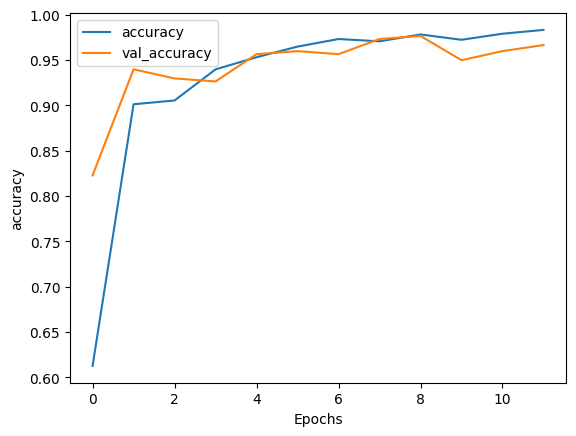

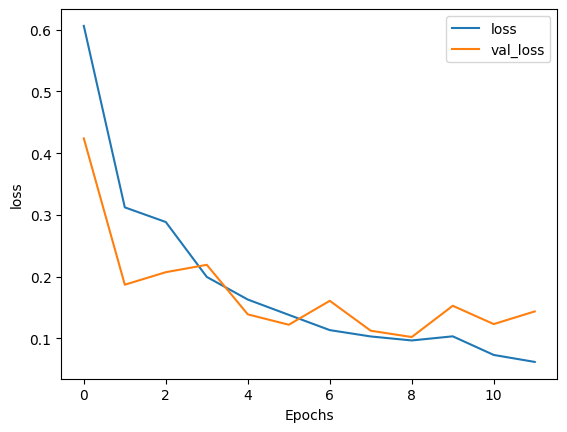

In [36]:
# plot graph of accuracy and loss over time
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [37]:
# save the model and weights
model_lstm.save('spam_classifier_lstm.h5')

## BiLSTM Architecture and Training

In [38]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_bilstm.add(Bidirectional(LSTM(n_lstm, return_sequences=False)))
model_bilstm.add(Dropout(drop))
model_bilstm.add(Dense(1, activation='sigmoid'))

model_bilstm.build(input_shape=(None, max_len))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_bilstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 50, 16)         │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       148,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,737 (612.25 KB)

 Trainable params: 156,737 (612.25 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history_bilstm = model_bilstm.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

Epoch 1/30
38/38 - 8s - 199ms/step - accuracy: 0.6619 - loss: 0.6275 - val_accuracy: 0.7893 - val_loss: 0.5385
Epoch 2/30
38/38 - 3s - 89ms/step - accuracy: 0.8561 - loss: 0.3564 - val_accuracy: 0.9431 - val_loss: 0.1859
Epoch 3/30
38/38 - 3s - 83ms/step - accuracy: 0.9464 - loss: 0.1722 - val_accuracy: 0.9331 - val_loss: 0.1438
Epoch 4/30
38/38 - 3s - 73ms/step - accuracy: 0.9339 - loss: 0.1772 - val_accuracy: 0.9532 - val_loss: 0.1721
Epoch 5/30
38/38 - 3s - 86ms/step - accuracy: 0.9657 - loss: 0.1194 - val_accuracy: 0.9599 - val_loss: 0.1394
Epoch 6/30
38/38 - 4s - 94ms/step - accuracy: 0.9699 - loss: 0.0965 - val_accuracy: 0.9666 - val_loss: 0.1259
Epoch 7/30
38/38 - 3s - 80ms/step - accuracy: 0.9766 - loss: 0.0805 - val_accuracy: 0.9699 - val_loss: 0.1143
Epoch 8/30
38/38 - 3s - 67ms/step - accuracy: 0.9732 - loss: 0.0846 - val_accuracy: 0.8729 - val_loss: 0.2386
Epoch 9/30
38/38 - 2s - 63ms/step - accuracy: 0.9757 - loss: 0.0774 - val_accuracy: 0.9699 - val_loss: 0.1725


In [40]:
model_bilstm.evaluate(testing_padded, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9692 - loss: 0.1683


[0.17247411608695984, 0.9698996543884277]

In [41]:
training_bil_results = model_bilstm.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_bil_results = model_bilstm.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)

print(f'Train accuracy: {training_bil_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_bil_results[1]*100:0.2f}')

5/5 - 1s - 169ms/step - accuracy: 0.9791 - loss: 0.0649
2/2 - 0s - 122ms/step - accuracy: 0.9699 - loss: 0.1725
Train accuracy: 97.91
Valid accuracy: 96.99


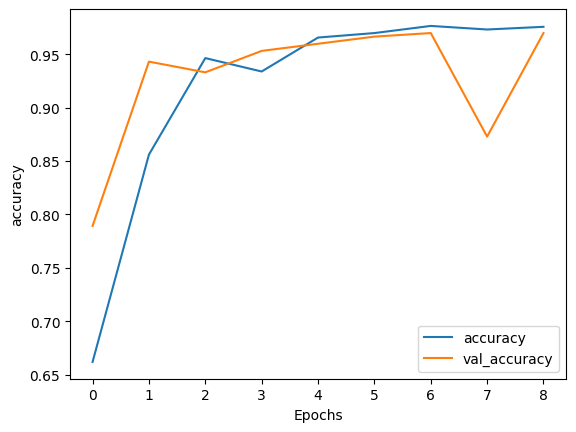

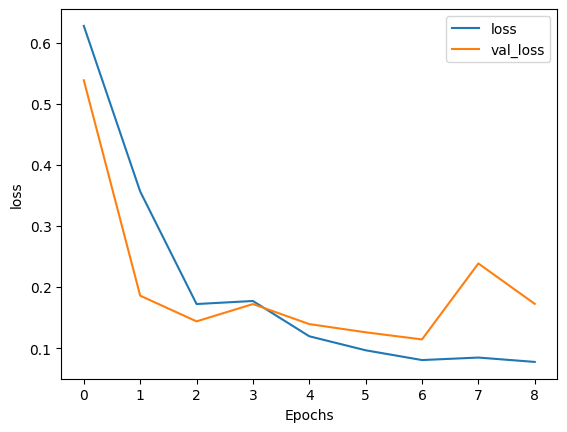

In [42]:
# plot graph of accuracy and loss over time
plot_graphs(history_bilstm, 'accuracy')
plot_graphs(history_bilstm, 'loss')

In [43]:
#save the model
model_bilstm.save('spam_classifier_bilstm.h5')


## GRU 


In [44]:
model_gru = Sequential()
model_gru.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model_gru.add(SpatialDropout1D(drop))
model_gru.add(GRU(n_lstm, return_sequences=False))
model_gru.add(Dropout(drop))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.build(input_shape=(None, max_len))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 50, 16)         │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 50, 16)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        56,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,193 (250.75 KB)

 Trainable params: 64,193 (250.75 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history_gru = model_gru.fit(training_padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[early_stop], verbose=2)

Epoch 1/30
38/38 - 8s - 211ms/step - accuracy: 0.4921 - loss: 0.6936 - val_accuracy: 0.4548 - val_loss: 0.6975
Epoch 2/30
38/38 - 3s - 80ms/step - accuracy: 0.5113 - loss: 0.6930 - val_accuracy: 0.4548 - val_loss: 0.6950
Epoch 3/30
38/38 - 3s - 85ms/step - accuracy: 0.4979 - loss: 0.6944 - val_accuracy: 0.4548 - val_loss: 0.6970
Epoch 4/30
38/38 - 3s - 85ms/step - accuracy: 0.5113 - loss: 0.6937 - val_accuracy: 0.4548 - val_loss: 0.6948
Epoch 5/30
38/38 - 3s - 86ms/step - accuracy: 0.5121 - loss: 0.6934 - val_accuracy: 0.4548 - val_loss: 0.6952
Epoch 6/30
38/38 - 3s - 83ms/step - accuracy: 0.5113 - loss: 0.6932 - val_accuracy: 0.4548 - val_loss: 0.6950


In [46]:
model_gru.evaluate(testing_padded, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4438 - loss: 0.6957


[0.6949668526649475, 0.454849511384964]

In [47]:
training_gru_results = model_gru.evaluate(training_padded, np.asarray(y_train), verbose=2, batch_size=256)
valid_gru_results = model_gru.evaluate(testing_padded, np.asarray(y_test), verbose=2, batch_size=256)

print(f'Train accuracy: {training_gru_results[1]*100:0.2f}')
print(f'Valid accuracy: {valid_gru_results[1]*100:0.2f}')

5/5 - 1s - 142ms/step - accuracy: 0.5113 - loss: 0.6926
2/2 - 0s - 128ms/step - accuracy: 0.4548 - loss: 0.6950
Train accuracy: 51.13
Valid accuracy: 45.48


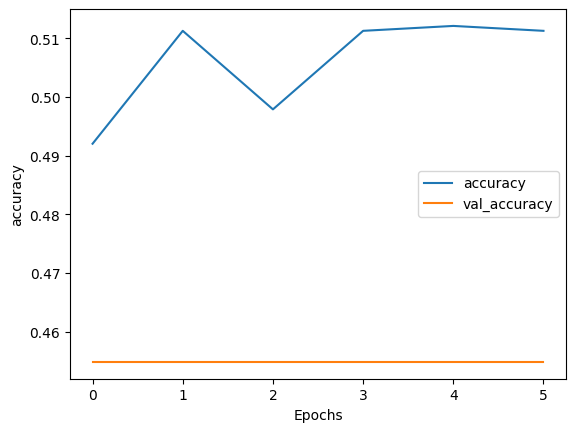

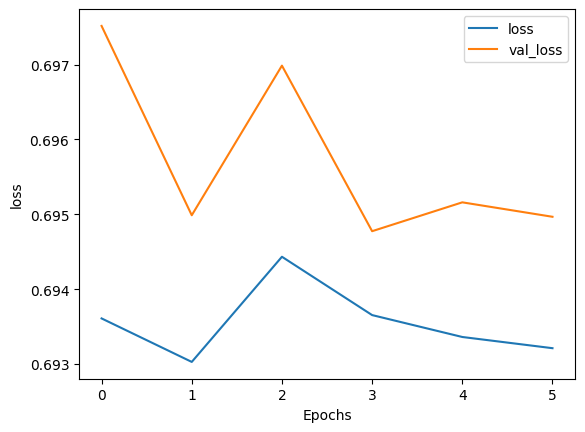

In [48]:
#plot graph of accuracy and loss over time
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

In [49]:
model_gru.save('spam_classifier_gru.h5')

## Comparision of Models

In [50]:
# tabulatw the results

results = pd.DataFrame({'Model': ['Dense', 'LSTM', 'BiLSTM', 'GRU'],
                        'Train Accuracy': [train_dense_results[1], train_lstm_results[1], training_bil_results[1], training_gru_results[1]],
                        'Valid Accuracy': [valid_dense_results[1], valid_lstm_results[1], valid_bil_results[1], valid_gru_results[1]]})

results

,Model,Train Accuracy,Valid Accuracy
0,Dense,0.978243,0.969900
1,LSTM,0.987448,0.966555
2,BiLSTM,0.979079,0.969900
3,GRU,0.511297,0.454850


## Predicting on New Messages

In [51]:
def predict_spam(model, text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
    prediction = model.predict(padded)
    return prediction

In [52]:
text = ["Have friends and colleagues who could benefit from these weekly updates? Send them to this link to subscribe",
        "Call me"]

predict_spam(model_bilstm, text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step


array([[0.9993868 ],
       [0.03724608]], dtype=float32)